(geopandas1)=
# Vector layers (`geopandas`)

In [40]:
!echo Last updated: `date +'%Y-%m-%d %H:%M:%S'`

Last updated: 2022-07-14 10:59:09


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams['figure.figsize'] = (6, 6)

*****

## Introduction

In the previous chapter, we worked with individual geometries using the `shapely` package ({ref}`shapely`). In GIS paractice, however, we usually work with *vector layers*, rather than individual geometries. Vector layers can be thought of:

* a collection of (one or more) geometries, 
* associated with a Coordinate Reference System (CRS), and 
* associated with (zero or more) non-spatial attributes.

In this chapter, we introduce the `geopandas` package for working with vector layers. First, we are going to see how a vector layer can be created from scratch (see {ref}`layer-from-scratch`), using `shapely` geometries, to understand the relation between `shapely` geometries and `geopandas` data structures, namely: 

* `GeoSeries`—A geometry column, i.e., a collection of geometries along with a CRS definition
* `GeoDataFrame`—A vector layer


Then, we go on to cover some of the basic operations and workflows with vector layers using the `geopandas` package:

* {ref}`reading-vector-layers`—Importing a vector layer from a file, such as a Shapefile
* {ref}`geopandas-plotting`—Plotting vector layers
* {ref}`subsetting-by-attributes`—Selecting features by attribute
* {ref}`point-layer-from-table`—Creating a point layer from a table
* {ref}`geopandas-points-to-line`—Converting a point layer to a line layer
* {ref}`geopandas-writing`—Writing a vector layer to file

In the next chapter, we are going to cover *spatial* operations with `geopandas`, such as calculating new geometries (buffers, etc.) and spatial join (see {ref}`geopandas2`).

(what-is-geopandas)=
## What is `geopandas`?

`geopandas`, as the name suggests, is an extension of `pandas` that enables working with spatial (geographic) data, specifically with *vector layers*. To facilitate the representation of spatial data, `geopandas` defines two data structures, which are extensions of the analogous data structures from `pandas` for non-spatial data:

* `GeoSeries`—An extension of a `Series` (see {ref}`creating-series`) for storing a sequence of geometries and a Coordinate Reference System (CRS) definition, whereas each geometry is a `shapely` object (see {ref}`shapely`)
* `GeoDataFrame`—An extension of a `DataFrame` (see {ref}`creating-dataframe`), where one of the columns is a `GeoSeries`

As will be demostrated in a moment (see {ref}`layer-from-scratch`), a `GeoDataFrame`, representing a *vector layer*, is thus a combination ({numref}`geodataframe-structure-fig`) of: 

* A `GeoSeries`, which holds the geometries in a special "geometry" column 
* Zero or more `Series`, which represent the non-spatial attributes

Since `geopandas` is based on `pandas`, many of the `DataFrame` workflows and operators we learned about earlier (see {ref}`pandas1` and {ref}`pandas2`) work exactly the same way with a `GeoDataFrame`. This is especially true for operations that involve just the non-spatial properties, such as filtering by attributes (see {ref}`subsetting-by-attributes`). 

```{figure} images/geodataframe.svg
---
name: geodataframe-structure-fig
---
`GeoDataFrame` structure (source: <https://geopandas.org/getting_started/introduction.html>)
```

The `geopandas` package depends on several other Python packages, most importantly:

* `numpy`
* `pandas`
* `shapely`—Interface to [GEOS](https://trac.osgeo.org/geos) (see {ref}`shapely`)
* `fiona`—Interface to [GDAL](https://gdal.org/)
* `pyproj`—Interface to [PROJ](https://proj.org/)

To put it in perspective of other packages, `geopandas` may be considered a high-level approach for working with vector layers in Python. A lower-level approach is provided through the `fiona` package, which `geopandas` depends on. The `osgeo` package provides (through its `ogr` object) another, more low-level, approach for vector layer access {cite}`garrard2016geoprocessing`.

Since `geopandas` is simpler to learn and work with than its alternatives, it is the recommended approach for the purposes in this book. For instance, using `fiona` and `osgeo` we typically have to process vector features one-by-one inside a `for` loop, while in `geopandas` the entire layer is being 'read' and processed at once. Nevertheless, in some situations it is necessary to resort to lower-level approaches. For example, processing features one-by-one is essential when the layer is too big to fit in memory.

(geopandas-creating-from-scratch)=
## Creating from scratch

(geoseries-from-scratch)=
### Creating a `GeoSeries`

Before starting to work with `geopandas`, we have to load it. We also load `pandas`, `shapely.geometry`, and `shapely.wkt`, which we are already familiar with, since they are needed for some of the examples:

In [42]:
import pandas as pd
import shapely.geometry
import shapely.wkt
import geopandas as gpd

As a first step to learn about `geopandas`, we are going to create a geometry column (`GeoSeries`), and then a vector layer (`GeoDataFrame`) (see {ref}`layer-from-scratch`) from sratch. This will help us get a better understanding of the structure of a `GeoDataFrame` ({numref}`geodataframe-structure-fig`).

Let us start with the geometry column, i.e., a `GeoSeries`. The geometric component of our layer is going to be a sequence of two `'Polygon"` geometries, hereby named `pol1` and `pol2` (see {ref}`shapely-from-wkt`):

In [43]:
pol1 = shapely.wkt.loads('POLYGON ((0 0, 0 -1, 7.5 -1, 7.5 0, 0 0))')
pol2 = shapely.wkt.loads('POLYGON ((0 1, 1 0, 2 0.5, 3 0, 4 0, 5 0.5, 6 -0.5, 7 -0.5, 7 1, 0 1))')

To create a `GeoSeries`, we can pass a `list` of `shapely` geometries to the `gpd.GeoSeries` function. The second (optional) argument passed to `gpd.GeoSeries` is a `crs`, specifying the Coordinate Reference System (CRS). In this case, we specify the WGS84 geographical CRS, using its EPSG code `4326` ({numref}`crs`):

In [44]:
s = gpd.GeoSeries([pol1, pol2], crs=4326)
s

0    POLYGON ((0.00000 0.00000, 0.00...
1    POLYGON ((0.00000 1.00000, 1.00...
dtype: geometry

(layer-from-scratch)=
### Creating a `GeoDataFrame`

A `GeoDataFrame` can be constructed from a `dict` representing the columns, one of them containing the geometries, and the other(s) containing non-spatial attributes (if any). The `dict` values may be `Series`, `GeoSeries`, or `list` data structure. First, let us create the dictionary:

In [45]:
d = {'name': ['a', 'b'], 'geometry': s}
d

{'name': ['a', 'b'],
 'geometry': 0    POLYGON ((0.00000 0.00000, 0.00...
 1    POLYGON ((0.00000 1.00000, 1.00...
 dtype: geometry}

In this particular case, we have: 

* the (mandatory) geometry column, conventionally named `'geometry'`, specified using a `GeoSeries` (see {ref}`geoseries-from-scratch`), and 
* one non-spatial attribute, named `'name'`, specified using a `list`

Now, we can convert the `dict` to a `GeoDataFrame`, using the `gpd.GeoDataFrame` function:

In [46]:
gdf = gpd.GeoDataFrame(d)
gdf

name                            geometry
0    a  POLYGON ((0.00000 0.00000, 0.00...
1    b  POLYGON ((0.00000 1.00000, 1.00...

or in a single step:

In [47]:
gdf = gpd.GeoDataFrame({'name': ['a', 'b'], 'geometry': s})
gdf

name                            geometry
0    a  POLYGON ((0.00000 0.00000, 0.00...
1    b  POLYGON ((0.00000 1.00000, 1.00...

We can also use a `list` of geometries instead of a `GeoSeries`, in which case the `crs` can be specified inside `gpd.GeoDataFrame`:

In [48]:
gdf = gpd.GeoDataFrame({'name': ['a', 'b'], 'geometry': [pol1, pol2]}, crs=4326)
gdf

name                            geometry
0    a  POLYGON ((0.00000 0.00000, 0.00...
1    b  POLYGON ((0.00000 1.00000, 1.00...

Note that, the workflow to create a `GeoDataFrame` is very similar to the way we created a `DataFrame` with the `pd.DataFrame` function (see {ref}`creating-dataframe`). Basically, the only difference is the presence of the geometry column.

(geodataframe-structure)=
## `GeoDataFrame` structure

### `Series` columns

Let us examine the structure of the `gdf` object we just created to understand the structure of a `GeoDataFrame`. 

An individual column of a `GeoDataFrame` can be accessed just like a column of a `DataFrame` (see {ref}`dataframe-selecting-columns`). For example, the following expression returns the `"name"` column:

In [49]:
gdf['name']

0    a
1    b
Name: name, dtype: object

as a `Series` object:

In [50]:
type(gdf['name'])

pandas.core.series.Series

More specifically, `'name'` is a `Series` of type `object`, since it contains strings.

(geoseries-geometry-column)=
### `GeoSeries` (geometry) column

The following expression returns the `'geometry'` column:

In [51]:
gdf['geometry']

0    POLYGON ((0.00000 0.00000, 0.00...
1    POLYGON ((0.00000 1.00000, 1.00...
Name: geometry, dtype: geometry

As mentioned above, the geometry column is a `GeoSeries` object:

In [52]:
type(gdf['geometry'])

geopandas.geoseries.GeoSeries

The `'geometry'` column is what differentiates a `GeoDataFrame` from an ordinary `DataFrame`. 

(geopandas-individual-geometries)=
### Individual geometries

As evident from the way we constructed the object (see {ref}`layer-from-scratch`), each "cell" in the geometry column is an individual `shapely` geometry:

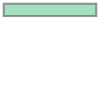

In [53]:
gdf['geometry'].iloc[0]

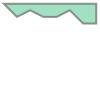

In [54]:
gdf['geometry'].iloc[1]

If necessary, for instance when applying `shapely` functions (see {ref}`geopandas-points-to-line`), the entire geometry column can be extracted as a `list` of `shapely` geometries using `to_list` (see {ref}`pandas-series-to-list`):

In [55]:
gdf['geometry'].to_list()

(geodataframe-properties)=
## `GeoDataFrame` properties

### Geometry types

The geometry types ({numref}`feature-types`) of the geometries in a `GeoDataFrame` or a `GeoSeries` can be obtained using the [`.geom_type`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.geom_type.html) property. The result is a `Series` of strings, with the geometry type names. For example:

In [56]:
s.geom_type

0    Polygon
1    Polygon
dtype: object

In [57]:
gdf.geom_type

0    Polygon
1    Polygon
dtype: object

The `.geom_type` property of `geopandas` thus serves the same purpose as the `.geom_type` property of `shapely` geometries (see {ref}`shapely-geometry-type`).

(geopandas-crs)=
### Coordinate Reference System (CRS)

In addition to the geometries, a `GeoSeries` has a property named [`.crs`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.crs.html), which specifies the Coordinate Regerence System (CRS) of the geometries. For example, the geometries in the `gdf` layer are in the geographic WGS84 CRS, as specified when creating the layer (see {ref}`layer-from-scratch`):

In [58]:
gdf['geometry'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The `.crs` property can also be reached from the `GeoDataFrame` itself:

In [59]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We are going to elaborate on CRS and modifying them later on (see {ref}`geopandas-reprojection`). 

(geopandas-bounds)=
### Bounds (`geopandas`)

The [`.total_bounds`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html), property of a `GeoDataFrame` contains the bounding box coordinates of all geometries combined, in the form of a `numpy` array:

In [60]:
gdf.total_bounds

array([ 0. , -1. ,  7.5,  1. ])

For more detailed information, the [`.bounds`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.bounds.html) property returns the bounds of each geometry, separately, in a `DataFrame`:

In [61]:
gdf.bounds

minx  miny  maxx  maxy
0   0.0  -1.0   7.5   0.0
1   0.0  -0.5   7.0   1.0

In both cases, bounds are returned in the standard form $(x_{min}$, $y_{min}$, $x_{max}$, $y_{max})$, in agreement with the `.bounds` property of `shapely` (see {ref}`shapely-bounding-box`).

(reading-vector-layers)=
## Reading vector layers

Usually, we read a vector layer from a file, rather than creating it from scratch (see {ref}`layer-from-scratch`). The `gpd.read_file` function can read vector layer files in any of the common formats, such as: 

* Shapefile (`.shp`)
* GeoJSON (`.geojson`)
* GeoPackage (`.gpkg`)
* File Geodatabase (`.gdb`)

For example, the following expression reads a Shapefile named `muni_il.shp` into a `GeoDataFrame` named `towns`. This is a polygonal layer of towns in Israel. The additional `encoding='utf-8'` argument makes the Hebrew text correctly interpreted:

In [62]:
towns = gpd.read_file('data/muni_il.shp', encoding='utf-8')
towns

Muni_Heb                        Muni_Eng      Sug_Muni  \
0    ללא שיפוט - אזור מעיליא  No Jurisdiction - Mi'ilya Area     ללא שיפוט   
1                        תמר                           Tamar  מועצה אזורית   
2                        שהם                          Shoham  מועצה מקומית   
3                        שהם                          Shoham  מועצה מקומית   
4                   ראש פינה                       Rosh Pina  מועצה מקומית   
..                       ...                             ...           ...   
405                   אופקים                          Ofakim        עירייה   
406                אבן יהודה                     Even Yehuda  מועצה מקומית   
407                 אבו סנאן                        Abu Snan  מועצה מקומית   
408                  אבו גוש             Abu Gosh (Abu Rosh)  מועצה מקומית   
409                 שדות נגב                      Sdot Negev  מועצה אזורית   

     ...   T10   T11                            geometry  
0    ...  None  None  POLYGON Z ((225369.655 770523.6...  
1    ...  None  None  POLYGON Z ((206899.135 552967.8...  
2    ...  None  None  POLYGON Z ((194329.250 655299.1...  
3    ...  None  None  POLYGON Z ((196236.573 657835.0...  
4    ...  None  None  POLYGON Z ((255150.135 764764.6...  
..   ...   ...   ...                                 ...  
405  ...  None  None  POLYGON Z ((164806.146 577898.8...  
406  ...  None  None  POLYGON Z ((189803.359 684152.9...  
407  ...  None  None  POLYGON Z ((212294.953 763168.8...  
408  ...  None  None  POLYGON Z ((209066.649 635655.2...  
409  ...  None  None  POLYGON Z ((162082.027 592043.1...  

[410 rows x 38 columns]

Let us read another layer, `RAIL_STRATEGIC.shp`, into a `GeoDataFrame` named `rail`. This is a line layer of railway lines in Israel:

In [63]:
rail = gpd.read_file('data/RAIL_STRATEGIC.shp')
rail

UPGRADE    SHAPE_LENG    SHAPE_Le_1  ... ISACTIVE  \
0    שדרוג 2040  14489.400742  12379.715332  ...     פעיל   
1    שדרוג 2030   2159.344166   2274.111800  ...     פעיל   
2    שדרוג 2040   4942.306156   4942.306156  ...  לא פעיל   
3    שדרוג 2040   2829.892202   2793.337699  ...     פעיל   
4    שדרוג 2040   1976.490872   1960.170882  ...     פעיל   
..          ...           ...           ...  ...      ...   
212    חדש 2030   2174.401983   2174.401983  ...  לא פעיל   
213    חדש 2030      0.000000    974.116931  ...  לא פעיל   
214  שדרוג 2030   3248.159569   1603.616014  ...     פעיל   
215  שדרוג 2030   2611.879099    166.180958  ...     פעיל   
216  שדרוג 2030   1302.971893   1284.983680  ...     פעיל   

                    UPGRAD                            geometry  
0    שדרוג בין 2030 ל-2040  LINESTRING (205530.083 741562.9...  
1            שדרוג עד 2030  LINESTRING (181507.598 650706.1...  
2    שדרוג בין 2030 ל-2040  LINESTRING (189180.643 645433.4...  
3    שדרוג בין 2030 ל-2040  LINESTRING (203482.789 744181.5...  
4    שדרוג בין 2030 ל-2040  LINESTRING (178574.101 609392.9...  
..                     ...                                 ...  
212          פתיחה עד 2030  LINESTRING (195887.590 675861.9...  
213          פתיחה עד 2030  LINESTRING (183225.361 648648.2...  
214          שדרוג עד 2030  LINESTRING (200874.999 746209.3...  
215          שדרוג עד 2030  LINESTRING (203769.786 744358.6...  
216          שדרוג עד 2030  LINESTRING (190553.481 654170.3...  

[217 rows x 7 columns]

```{note}
Note that a Shapefile consists of several files, such as `.shp`, `.shx`, `.dbf` and `.prj`, even though we specify just one the `.shp` file path when reading a Shapefile with `gpd.read_file`. The same applies to writing a Shapefile (see {ref}`geopandas-writing`).
```

(geopandas-plotting)=
## Plotting (`geopandas`)

(geopandas-basic-plots)=
### Basic plots

A `GeoDataFrame` object has a [`.plot`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) method, which can be used to visually examine the layer we are working with. For example:

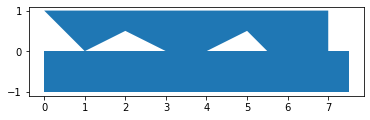

In [64]:
gdf.plot();

We can use the `color` and `edgecolor` parameters to specify the fill color and border color, respectively:

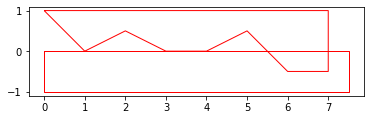

In [65]:
gdf.plot(color="none", edgecolor="red");

Another useful property is `linewidth`, to specify line width: 

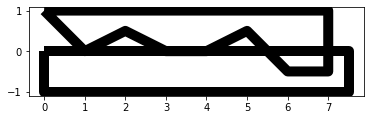

In [66]:
gdf.plot(color='none', linewidth=10);

Let us also plot the `towns` and `rail` layers to see what they look like:

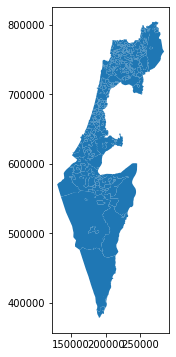

In [67]:
towns.plot();

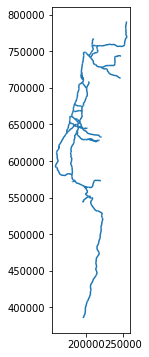

In [68]:
rail.plot();

(geopandas-symbology)=
### Setting symbology

By default, all plotted geometries share the same appearance. We can set a symbology, where the appearance corresponds to given attributes values, using the `column` parameter. For example, the following expression results in a map where town fill colors correspond to the `"Machoz"` attribute values. We can therefore see the "Machoz" administrative division:

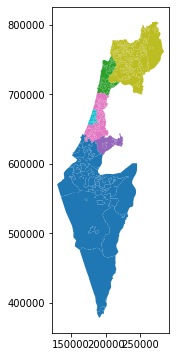

In [69]:
towns.plot(column='Machoz');

The color palette for the symbology can be changed using the `cmap` ("color map") argument. Valid palette names can be found in the [Choosing Colormaps](https://matplotlib.org/2.0.2/users/colormaps.html) page of the `matplotlib` documentation. For example, `"Set2"` is one of the "Qualitative colormaps", which is appropriate for categorical variables:

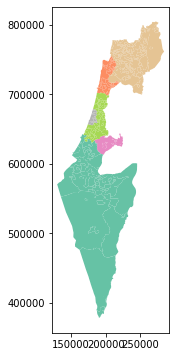

In [70]:
towns.plot(column='Machoz', cmap='Set2');

As another example, the following expression sets a symbology corresponding to the continuous `"Shape_Area"` (town area in square meters) columns. The argument `legend=True` adds a legend:

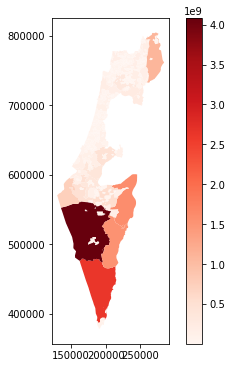

In [71]:
towns.plot(column='Shape_Area', cmap='Reds', legend=True);

(geopandas-interactive-maps)=
### Interactive maps

`geopandas` also provides the [`.explore`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) method, which facilitates interactive exploration of the vector layers we are working with. The `.explore` method takes many of the same arguments as `.plot` (such as `column` and `cmap`), but also some specific ones (such as `style_kwds`). See the [documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) for details.

For example, the following expression creates an interactive map displaying the `rail` layer, colored according to status (active or not). Note that hovering over a feature with the mouse shows a tooltip with the attribute values (similarly to "identify" tools in GIS software).

In [72]:
rail.explore(column='ISACTIVE', cmap='RdYlBu', style_kwds={'weight':8, 'opacity':0.8})

```{note}
There are several Python packages for creating interactive maps displaying spatial data, either inside a Jupyter notebook or exporting to an HTML document. Most notably, these include `folium`, `ipyleaflet`, `leafmap`, and `bokeh`. All but the last one are based on the Leaflet web-mapping JavaScript package. The `.explore` method of `geopandas`, in fact, uses the `folium` package and requires it to be installed.
```

(geopandas-plotting-more-than-one-layer)=
### Plotting more than one layer

It is is often helpful to display several layers together in the same plot, one on top of the other. That way, we can see the orientation and alignment of several layers at once.

To display two or more layers in the same `geopandas` plot, we need to do things a little differently than shown above (see {ref}`geopandas-basic-plots`): 

* First, we need to assign a specific plot (with one of the layers), to a variable, such as `base`. This serves as the "base" plot. 
* Then, we can display any additional layer on top of the base plot using its `.plot` method, while passing the base plot object to the `ax` parameter, as in `ax=base`.

For example, here is how we can plot both `towns` and `rail`, one on top of the other. Note that we use `color="none"` for transparent fill of the polygons:

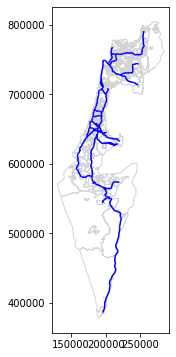

In [73]:
base = towns.plot(color='none', edgecolor='lightgrey')
rail.plot(ax=base, color='blue');

```{note}
More information on plotting `geopandas` layers can be found in <https://geopandas.org/docs/user_guide/mapping.html>.
```

## Selecting `GeoDataFrame` columns

We can subset columns in a `GeoDataFrame` the same way as in a `DataFrame`, using the `[[` operator (see {ref}`dataframe-selecting-columns`). The only thing we need to keep in mind is that we must keep the `"geometry"` column, so that the result remains a vector *layer* rather than an ordinary table. 

For example, the following expression subsets 5 out of the 23 columns in `towns`:

In [74]:
towns = towns[["Muni_Heb", "Muni_Eng", "Machoz", "Shape_Area", "geometry"]]
towns

Muni_Heb                        Muni_Eng   Machoz  \
0    ללא שיפוט - אזור מעיליא  No Jurisdiction - Mi'ilya Area     צפון   
1                        תמר                           Tamar     דרום   
2                        שהם                          Shoham     מרכז   
3                        שהם                          Shoham     מרכז   
4                   ראש פינה                       Rosh Pina     צפון   
..                       ...                             ...      ...   
405                   אופקים                          Ofakim     דרום   
406                אבן יהודה                     Even Yehuda     מרכז   
407                 אבו סנאן                        Abu Snan     צפון   
408                  אבו גוש             Abu Gosh (Abu Rosh)  ירושלים   
409                 שדות נגב                      Sdot Negev     דרום   

       Shape_Area                            geometry  
0    2.001376e+05  POLYGON Z ((225369.655 770523.6...  
1    1.597418e+09  POLYGON Z ((206899.135 552967.8...  
2    6.177438e+06  POLYGON Z ((194329.250 655299.1...  
3    9.850450e+05  POLYGON Z ((196236.573 657835.0...  
4    6.104233e+04  POLYGON Z ((255150.135 764764.6...  
..            ...                                 ...  
405  1.635240e+07  POLYGON Z ((164806.146 577898.8...  
406  8.141962e+06  POLYGON Z ((189803.359 684152.9...  
407  6.455340e+06  POLYGON Z ((212294.953 763168.8...  
408  1.891242e+06  POLYGON Z ((209066.649 635655.2...  
409  2.554627e+05  POLYGON Z ((162082.027 592043.1...  

[410 rows x 5 columns]

And here we subset three of the columns in `rail`:

In [75]:
rail = rail[['SEGMENT', 'ISACTIVE', 'geometry']]
rail

SEGMENT ISACTIVE  \
0                כפר יהושע - נשר_1     פעיל   
1               באר יעקב-ראשונים_2     פעיל   
2                     נתבג - נען_3  לא פעיל   
3            לב המפרץ מזרח - נשר_4     פעיל   
4                קרית גת - להבים_5     פעיל   
..                             ...      ...   
212  ראש העין צפון - כפר סבא צפון_  לא פעיל   
213          רמלה דרום-ראשונים_218  לא פעיל   
214          השמונה - בית המכס_220     פעיל   
215        לב המפרץ - בית המכס_221     פעיל   
216            224_לוד מרכז - נתבג     פעיל   

                               geometry  
0    LINESTRING (205530.083 741562.9...  
1    LINESTRING (181507.598 650706.1...  
2    LINESTRING (189180.643 645433.4...  
3    LINESTRING (203482.789 744181.5...  
4    LINESTRING (178574.101 609392.9...  
..                                  ...  
212  LINESTRING (195887.590 675861.9...  
213  LINESTRING (183225.361 648648.2...  
214  LINESTRING (200874.999 746209.3...  
215  LINESTRING (203769.786 744358.6...  
216  LINESTRING (190553.481 654170.3...  

[217 rows x 3 columns]

(subsetting-by-attributes)=
## Filtering by attributes

We can subset the rows (i.e., features) of a `GeoDataFrame` using a corresponding boolean `Series`, the same way we subset rows of a `DataFrame` (see {ref}`dataframe-filtering`). Typically, the boolean `Series` is the result of applying a conditional operator on one or more columns of the same `GeoDataFrame`. 

For example, suppose that we want to retain just the active railway segments from the `rail` layer, namely those segments where the value in the `"ISACTIVE"` column is equal to `"פעיל"` ("active"). First, we need to create a boolean series where `True` values reflect the rows we would like to retain. Here, we assign the boolean `Series` to a variable named `sel`:

In [76]:
sel = rail['ISACTIVE'] == 'פעיל'
sel

0       True
1       True
2      False
3       True
4       True
       ...  
212    False
213    False
214     True
215     True
216     True
Name: ISACTIVE, Length: 217, dtype: bool

Second, we need to pass the series as an index to the `GeoDataFrame`. As a result, `rail` now contains only the active railway lines (161 features out of 217):

In [77]:
rail = rail[sel]
rail

SEGMENT ISACTIVE                            geometry
0             כפר יהושע - נשר_1     פעיל  LINESTRING (205530.083 741562.9...
1            באר יעקב-ראשונים_2     פעיל  LINESTRING (181507.598 650706.1...
3         לב המפרץ מזרח - נשר_4     פעיל  LINESTRING (203482.789 744181.5...
4             קרית גת - להבים_5     פעיל  LINESTRING (178574.101 609392.9...
5            רמלה - רמלה מזרח_6     פעיל  LINESTRING (189266.580 647211.5...
..                          ...      ...                                 ...
210           ויתקין - חדרה_215     פעיל  LINESTRING (190758.230 704950.0...
211  בית יהושע - נתניה ספיר_216     פעיל  LINESTRING (187526.597 687360.3...
214       השמונה - בית המכס_220     פעיל  LINESTRING (200874.999 746209.3...
215     לב המפרץ - בית המכס_221     פעיל  LINESTRING (203769.786 744358.6...
216         224_לוד מרכז - נתבג     פעיל  LINESTRING (190553.481 654170.3...

[161 rows x 3 columns]

Once you are more comfortable with the subsetting syntax you may prefer to do the operation in a single step, as follows:

In [78]:
rail = rail[rail['ISACTIVE'] == 'פעיל']

Let us plot the filtered `rail` layer, to see the effect visually:

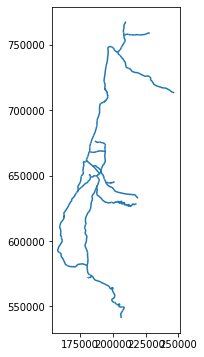

In [79]:
rail.plot();

```{admonition} Exercise 08-a
:class: important
* The layer `statisticalareas_demography2019.gdb` contains demographic data for the statistical areas of Israel, such as population size per age group, in 2019. For example, the column `"age_10_14"` contains population counts in the 10-14 age group, while the `"Pop_Total"` column contains total population counts (in all age groups). Note that `statisticalareas_demography2019.gdb` is in a format known as a File Geodatabase.
* Read the `statisticalareas_demography2019.gdb` layer into a `GeoDataFrame`.
* Subset the following columns (plus the geometry!):
    * `"YISHUV_STAT11"`—Statistical area ID
    * `"SHEM_YISHUV"`—Town name in Hebrew
    * `"SHEM_YISHUV_ENGLISH"`—Town name in English
    * `"Pop_Total"`—Total population size
* What is the Coordinate Reference System of the layer? (answer: `"Israel 1993 / Israeli TM Grid"`, i.e., "ITM")
* How many features does the layer contain? Write an expression that returns the result as `int`. (answer: `3195`)
* The values in the `"YISHUV_STAT11"` column (statistical area ID) should all be *unique*. How can you make sure? Either use one of the methods we learned earlier, or search online (e.g., google "pandas check for duplicates").
* Plot the layer using the `.plot` method ({numref}`exercise-08-a1`).
* Subset just the statistical areas of Beer-Sheva, using either the `"SHEM_YISHUV"` or the `"SHEM_YISHUV_ENGLISH"` column. 
* Plot the resulting subset, using symbology according to total population size, i.e., the `"Pop_Total"` column, and using a [sequentual color map](https://matplotlib.org/2.0.2/users/plotting/colormaps/lightness_01.png) such as `"Reds"` ({numref}`exercise-08-a2`). 
* How many statistical areas are there in Beer-Sheva? (answer: `62`)
* What was the *total* population of Beer-Sheva in 2019? (answer: `209685.0`)
```

```{glue:figure} exercise-08-a1
---
name: exercise-08-a1
---
Solution of exercise-08-a1: The statistical areas layer
```

```{glue:figure} exercise-08-a2
---
name: exercise-08-a2
---
Solution of exercise-08-a2: Statistical areas of Beer-Sheva, with symbology according to total population size
```

(point-layer-from-table)=
## Table to point layer

Another very common workflow of creating a vector layer is creating a point layer from a table that has X and Y coordinates in two separate columns. Technically, this means that the `X` and `Y` values in each row are transformed into a `"Point"` geometry. The geometries are then placed in a geometry column, so that the table becomes a vector layer.

To demonstrate, let us import the `stops.txt` table, which contains information about public transport stops in Israel based on GTFS data (see {ref}`what-is-gtfs`). Note the columns `stop_lon` and `stop_lat`, which contain the X and Y coordinates, in the WGS84 coordinate system, i.e., longitude and latitude, respectively:

In [80]:
stops = pd.read_csv('data/gtfs/stops.txt')
stops = stops[['stop_id', 'stop_name', 'stop_lon', 'stop_lat']]
stops

stop_id                 stop_name   stop_lon   stop_lat
0            1      בי''ס בר לב/בן יהודה  34.917554  32.183985
1            2            הרצל/צומת בילו  34.819541  31.870034
2            3            הנחשול/הדייגים  34.782828  31.984553
3            6       ת. מרכזית לוד/הורדה  34.898098  31.956392
4            8              הרצל/משה שרת  34.824106  31.857565
...        ...                       ...        ...        ...
28250    44668  חניון שפירים דרומי/הורדה  34.840406  32.001228
28251    44683                 מתחם נצבא  34.941549  32.112445
28252    44684                 מתחם נצבא  34.940668  32.111795
28253    44691              מסוף דרך שכם  35.228825  31.783680
28254    44692         הקוממיות/אנה פרנק  34.752376  32.002782

[28255 rows x 4 columns]

To transform a `DataFrame` with X and Y columns into a `GeoDataFrame` point layer, we go through two steps: 

* Constructing a `GeoSeries` of `"Point"` geometries, from two `Series` representing X and Y, using [`gpd.points_from_xy`](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html). Optionally, we can specify the CRS of the `GeoSeries`, using the `crs` parameter. 
* Converting the `GeoSeries` to a `GeoDataFrame`, using `gpd.GeoDataFrame`.

Let us begin with the first step—creating the `GeoSeries`. The X and Y columns are readily available, `stops["stop_lon"]`, `stops["stop_lat"]`, however specifying the `crs` parameter is less trivial. The CRS definition is usually not stored in the same table with the X and Y columns, since it would have to be repeated on all rows. We need to figure out which CRS the X and Y coordinates are in according to the metadata or accompanying information (such as the [GTFS specification](https://gtfs.org/schedule/reference/#stopstxt)). In this particular case, the names `stop_lon` and `stop_lat` (where lon=longitude and lat=latitude) give a pretty good hint that the coordinates are given in WGS84, therefore we use `crs=4326`:

In [81]:
geom = gpd.points_from_xy(stops['stop_lon'], stops['stop_lat'], crs=4326)

The result is a special type of array named [`GeometryArray`](https://jorisvandenbossche.github.io/blog/2019/08/13/geopandas-extension-array-refactor/):

In [82]:
type(geom)

geopandas.array.GeometryArray

Though it can be used as is, we are going to convert it to a `GeoSeries`, which we are already familiar with, for clarity:

In [83]:
geom = gpd.GeoSeries(geom)
geom

0        POINT (34.91755 32.18398)
1        POINT (34.81954 31.87003)
2        POINT (34.78283 31.98455)
3        POINT (34.89810 31.95639)
4        POINT (34.82411 31.85757)
                   ...            
28250    POINT (34.84041 32.00123)
28251    POINT (34.94155 32.11245)
28252    POINT (34.94067 32.11180)
28253    POINT (35.22883 31.78368)
28254    POINT (34.75238 32.00278)
Length: 28255, dtype: geometry

Now, we can use the `gpd.GeoDataFrame` function to combine the `DataFrame` with the `GeoSeries`, to get a `GeoDataFrame`. Instead of passing a `dict` of columns, like we did when creating a layer manually (see {ref}`layer-from-scratch`), we pass a `DataFrame` and a `GeoSeries` to the `data` and `geometry` parameters, respectively:

In [84]:
stops = gpd.GeoDataFrame(data=stops, geometry=geom)
stops

stop_id                 stop_name   stop_lon   stop_lat  \
0            1      בי''ס בר לב/בן יהודה  34.917554  32.183985   
1            2            הרצל/צומת בילו  34.819541  31.870034   
2            3            הנחשול/הדייגים  34.782828  31.984553   
3            6       ת. מרכזית לוד/הורדה  34.898098  31.956392   
4            8              הרצל/משה שרת  34.824106  31.857565   
...        ...                       ...        ...        ...   
28250    44668  חניון שפירים דרומי/הורדה  34.840406  32.001228   
28251    44683                 מתחם נצבא  34.941549  32.112445   
28252    44684                 מתחם נצבא  34.940668  32.111795   
28253    44691              מסוף דרך שכם  35.228825  31.783680   
28254    44692         הקוממיות/אנה פרנק  34.752376  32.002782   

                        geometry  
0      POINT (34.91755 32.18398)  
1      POINT (34.81954 31.87003)  
2      POINT (34.78283 31.98455)  
3      POINT (34.89810 31.95639)  
4      POINT (34.82411 31.85757)  
...                          ...  
28250  POINT (34.84041 32.00123)  
28251  POINT (34.94155 32.11245)  
28252  POINT (34.94067 32.11180)  
28253  POINT (35.22883 31.78368)  
28254  POINT (34.75238 32.00278)  

[28255 rows x 5 columns]

The `"stop_lon"` and `"stop_lat"` columns are no longer necessary, because the information is already in the `"geometry"` columns. Therefore, they can be dropped:

In [85]:
stops = stops.drop(['stop_lon', 'stop_lat'], axis=1)
stops

stop_id                 stop_name                   geometry
0            1      בי''ס בר לב/בן יהודה  POINT (34.91755 32.18398)
1            2            הרצל/צומת בילו  POINT (34.81954 31.87003)
2            3            הנחשול/הדייגים  POINT (34.78283 31.98455)
3            6       ת. מרכזית לוד/הורדה  POINT (34.89810 31.95639)
4            8              הרצל/משה שרת  POINT (34.82411 31.85757)
...        ...                       ...                        ...
28250    44668  חניון שפירים דרומי/הורדה  POINT (34.84041 32.00123)
28251    44683                 מתחם נצבא  POINT (34.94155 32.11245)
28252    44684                 מתחם נצבא  POINT (34.94067 32.11180)
28253    44691              מסוף דרך שכם  POINT (35.22883 31.78368)
28254    44692         הקוממיות/אנה פרנק  POINT (34.75238 32.00278)

[28255 rows x 3 columns]

Plotting the resulting layer of public transport stations reveals the outline of Israel, with more sparse coverage in the southern part, which corresponds to population density pattern in the country. The `markersize` argument is used to for smaller point size to reduce overlap:

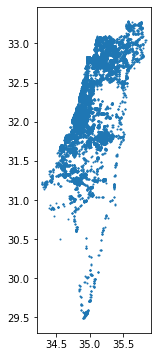

In [86]:
stops.plot(markersize=1);

(geopandas-points-to-line)=
## Points to line (`geopandas`)

(points-to-line-combine)=
### To lines: all points combined

A common type of geometry casting, which we already met when learning about `shapely` is the transformation of points to lines (see {ref}`shapely-geometry-casting`). Let us see how this type of casting can be acheived when our points are in a `GeoDataFrame`. We begin, in this section, with transforming an entire point layer to a single continuous line. In the next section, we will learn how to transform a point layer to a layer with multiple lines *by group* (see {ref}`geopandas-point-to-line-by-group`). 

To demonstrate, let us import the `shapes.txt` table (see {ref}`what-is-gtfs`) from the GTFS dataset. This table contains the *shapes* of public transit lines. This is quite a big table, with over 7 million rows. In the table, each shape is distinguished by a unique `"shape_id"`, comprised of lon/lat coordinates in the `"shape_pt_lat"`, `"shape_pt_lon"` columns:

In [87]:
shapes = pd.read_csv('data/gtfs/shapes.txt')
shapes

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0           44779     31.887695     35.016271                  1
1           44779     31.887745     35.016253                  2
2           44779     31.888256     35.016238                  3
3           44779     31.888913     35.016280                  4
4           44779     31.888917     35.016892                  5
...           ...           ...           ...                ...
7226268    123167     32.729572     35.331201                876
7226269    123167     32.729700     35.330923                877
7226270    123167     32.729706     35.330908                878
7226271    123167     32.729841     35.330538                879
7226272    123167     32.729899     35.330249                880

[7226273 rows x 4 columns]

For the first example, we take a subset of `shapes` containing the shape of just one transit line. We will select the `118789` value of `"shape_id"`, which corresponds to bus line 24 in Beer-Sheva going from Ramot to Beer-Sheva Central Bus Station (see {ref}`exercise-07-i_stops_pnt`). This results in a much smaller table, with 828 rows:

In [88]:
pnt = shapes[shapes["shape_id"] == 118789]
pnt

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
4264621    118789     31.280061     34.821551                  1
4264622    118789     31.280038     34.821704                  2
4264623    118789     31.280023     34.821880                  3
4264624    118789     31.280022     34.822029                  4
4264625    118789     31.280031     34.822072                  5
...           ...           ...           ...                ...
4265444    118789     31.242103     34.797988                826
4265445    118789     31.242829     34.797982                827
4265446    118789     31.242980     34.797986                828
4265447    118789     31.243121     34.798000                829
4265448    118789     31.243263     34.798017                830

[828 rows x 4 columns]

What we have is a `DataFrame` with x/y coordinate columns, `"shape_pt_lon"` and `"shape_pt_lat"`. We already know how to transform it to a `GeoDataFrame` with point geometries (see {ref}`point-layer-from-table`):

In [89]:
geom = gpd.points_from_xy(pnt['shape_pt_lon'], pnt['shape_pt_lat'], crs=4326)
pnt = gpd.GeoDataFrame(data=pnt, geometry=geom)
pnt

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  \
4264621    118789     31.280061     34.821551                  1   
4264622    118789     31.280038     34.821704                  2   
4264623    118789     31.280023     34.821880                  3   
4264624    118789     31.280022     34.822029                  4   
4264625    118789     31.280031     34.822072                  5   
...           ...           ...           ...                ...   
4265444    118789     31.242103     34.797988                826   
4265445    118789     31.242829     34.797982                827   
4265446    118789     31.242980     34.797986                828   
4265447    118789     31.243121     34.798000                829   
4265448    118789     31.243263     34.798017                830   

                          geometry  
4264621  POINT (34.82155 31.28006)  
4264622  POINT (34.82170 31.28004)  
4264623  POINT (34.82188 31.28002)  
4264624  POINT (34.82203 31.28002)  
4264625  POINT (34.82207 31.28003)  
...                            ...  
4265444  POINT (34.79799 31.24210)  
4265445  POINT (34.79798 31.24283)  
4265446  POINT (34.79799 31.24298)  
4265447  POINT (34.79800 31.24312)  
4265448  POINT (34.79802 31.24326)  

[828 rows x 5 columns]

The `"shape_pt_lat"` and `"shape_pt_lon"` columns are no longer necessary and can be dropped:

In [90]:
pnt = pnt.drop(['shape_pt_lon', 'shape_pt_lat'], axis=1)
pnt

shape_id  shape_pt_sequence                   geometry
4264621    118789                  1  POINT (34.82155 31.28006)
4264622    118789                  2  POINT (34.82170 31.28004)
4264623    118789                  3  POINT (34.82188 31.28002)
4264624    118789                  4  POINT (34.82203 31.28002)
4264625    118789                  5  POINT (34.82207 31.28003)
...           ...                ...                        ...
4265444    118789                826  POINT (34.79799 31.24210)
4265445    118789                827  POINT (34.79798 31.24283)
4265446    118789                828  POINT (34.79799 31.24298)
4265447    118789                829  POINT (34.79800 31.24312)
4265448    118789                830  POINT (34.79802 31.24326)

[828 rows x 3 columns]

Now, we are going use `shapely` to transform the point geometries into a single `"LineString"` geometry. First, we create a list of `shapely` geometries, which requires selecting the `GeoSeries` (geometry) column and converting it to a `list` the using `.to_list` method (see {ref}`geopandas-individual-geometries`):

In [91]:
x = pnt['geometry'].to_list()
x[:5]

Then, we use the `shapely.geometry.LineString` function (see {ref}`shapely-geometry-casting`) to convert the `list` of `"Point"` geometries to a single `"LineString"` geometry, as follows:

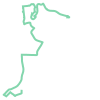

In [92]:
line = shapely.geometry.LineString(x)
line

In case we need the geometry to be contained in a `GeoDataFrame`, rather than a standalone `shapely` geometry, we can construct a `GeoDataFrame` using the methods we learned in the beginning of this chapter (see {ref}`layer-from-scratch`):

In [93]:
line1 = gpd.GeoDataFrame({'geometry': [line]}, crs=4326)
line1

geometry
0  LINESTRING (34.82155 31.28006, ...

Here is a plot of the resulting layer `line1`:

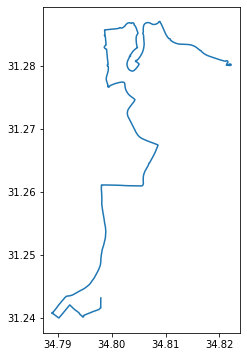

In [94]:
line1.plot();

(geopandas-point-to-line-by-group)=
### To lines: by group

In the next example, we demonstrate how the conversion of points to lines can be generalized to produce multiple lines at once, in case when there is a grouping variable specifying the division of points to groups. For example, using the GTFS data, we may want to create a layer of type `"LineString"`, with all different bus routes together, rahter than just one specific route (see {ref}`points-to-line-combine`). This example is relatively complex, with many steps to get the data into the right shape.

Our first step is to read four tables from the GTFS dataset, namely `agency`, `routes`, `trips`, and `shapes`:

In [95]:
agency = pd.read_csv('data/gtfs/agency.txt')
routes = pd.read_csv('data/gtfs/routes.txt')
trips = pd.read_csv('data/gtfs/trips.txt')
shapes = pd.read_csv('data/gtfs/shapes.txt')

We will also subset the most relevant columns of each table, for our purposes:

In [96]:
agency = agency[['agency_id', 'agency_name']]
routes = routes[['route_id', 'agency_id', 'route_short_name', 'route_long_name']]
trips = trips[['trip_id', 'route_id', 'shape_id']]
shapes = shapes[['shape_id', 'shape_pt_sequence', 'shape_pt_lon', 'shape_pt_lat']]

To have a more manageable layer size, we will subset just one bus operator, namely `"מטרופולין"`. First, we need to figure out its `agency_id`:

In [97]:
agency = agency[agency['agency_name'] == 'מטרופולין']
agency

agency_id agency_name
9         15   מטרופולין

Now that we know the `agency_id` of `"מטרופולין"`, we can subset the `routes` table to retain only the routes by this particular operator. We also drop the `"agency_id"` column which is no longer necessary. We can see there are `625` routes operated by `"מטרופולין"`:

In [98]:
routes = routes[routes['agency_id'] == agency['agency_id'].iloc[0]]
routes = routes.drop('agency_id', axis=1)
routes

route_id route_short_name                     route_long_name
235        696              600  ת. מרכזית נתניה/רציפים-נתניה<->...
236        697              600  ת.מרכזית ת''א ק.6/רציפים-תל אבי...
237        698              601  ת. רכבת נתניה-נתניה<->ת. מרכזית...
238        700              601  ת.מרכזית ת''א ק.6/רציפים-תל אבי...
239        707              604  ת. מרכזית נתניה/רציפים-נתניה<->...
...        ...              ...                                 ...
7148     28601               80  יהודה/חברון-ערד<->פלמ''ח/עין הת...
7149     28602               64  בי''ס שדה הר הנגב-מצפה רמון<->ת...
7156     28694              561  ת. רכבת קרית אריה-פתח תקווה<->ת...
7200     29130                1  מסוף קדמה-רמת השרון<->מסוף קדמה...
7201     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...

[625 rows x 3 columns]

Next, we need to join the `routes` table with the `shapes` table, where the route coordinates are. However the `routes` table corresponds to the `shapes` table indirectly, through the `trips` table ({numref}`gtfs-files-drawing`). Therefore we first need to join `trips` to `routes`, and then `shapes` to the result. To make things simpler, we will remove duplicates from the `trips` table, assuming that all trips of a particular route follow the same shape (which they typically do), thus retaining just one representative trip per route. Here is the current state of the `trips` table, with numerous trips per route:

In [99]:
trips

trip_id  route_id  shape_id
0       28876224_180421         1  121757.0
1       28876225_180421         1  121757.0
2       28876226_180421         1  121757.0
3       28876227_180421         1  121757.0
4       28876228_180421         1  121757.0
...                 ...       ...       ...
287673  56622686_230421     29363  123144.0
287674  56460152_180421     29364       NaN
287675  56458677_180421     29365   67648.0
287676  56458667_180421     29366   51396.0
287677  56458657_180421     29368  123033.0

[287678 rows x 3 columns]

To remove duplicates from a table, we can use the [`.drop_duplicates`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) method. This method accepts an argument named `subset`, where we specify which column(s) are considered for duplicates. In our case, we remove rows with duplicated `route_id` in `trips`, thus retaining just one `route_id` per trip:

In [100]:
trips = trips.drop_duplicates(subset='route_id')
trips

trip_id  route_id  shape_id
0       28876224_180421         1  121757.0
45      25448344_180421         2  121758.0
88      56334623_180421         3   97106.0
119     56335137_180421         5  121759.0
154     37173391_180421         7  119801.0
...                 ...       ...       ...
287668  56622661_230421     29363  123144.0
287674  56460152_180421     29364       NaN
287675  56458677_180421     29365   67648.0
287676  56458667_180421     29366   51396.0
287677  56458657_180421     29368  123033.0

[7251 rows x 3 columns]

We can also drop the `trip_id` column, which is no longer necessary:

In [101]:
trips = trips.drop('trip_id', axis=1)
trips

route_id  shape_id
0              1  121757.0
45             2  121758.0
88             3   97106.0
119            5  121759.0
154            7  119801.0
...          ...       ...
287668     29363  123144.0
287674     29364       NaN
287675     29365   67648.0
287676     29366   51396.0
287677     29368  123033.0

[7251 rows x 2 columns]

Now we can run both joins: 

* first joining `trips` to `routes`, to attach the shape IDs, 
* then `shapes` to the result, to attach the lon/lat point sequences

as follows:

In [102]:
routes

route_id route_short_name                     route_long_name
235        696              600  ת. מרכזית נתניה/רציפים-נתניה<->...
236        697              600  ת.מרכזית ת''א ק.6/רציפים-תל אבי...
237        698              601  ת. רכבת נתניה-נתניה<->ת. מרכזית...
238        700              601  ת.מרכזית ת''א ק.6/רציפים-תל אבי...
239        707              604  ת. מרכזית נתניה/רציפים-נתניה<->...
...        ...              ...                                 ...
7148     28601               80  יהודה/חברון-ערד<->פלמ''ח/עין הת...
7149     28602               64  בי''ס שדה הר הנגב-מצפה רמון<->ת...
7156     28694              561  ת. רכבת קרית אריה-פתח תקווה<->ת...
7200     29130                1  מסוף קדמה-רמת השרון<->מסוף קדמה...
7201     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...

[625 rows x 3 columns]

In [103]:
routes = pd.merge(routes, trips, on='route_id', how='left')
routes

route_id route_short_name                     route_long_name  shape_id
0         696              600  ת. מרכזית נתניה/רציפים-נתניה<->...  120512.0
1         697              600  ת.מרכזית ת''א ק.6/רציפים-תל אבי...  119606.0
2         698              601  ת. רכבת נתניה-נתניה<->ת. מרכזית...  112496.0
3         700              601  ת.מרכזית ת''א ק.6/רציפים-תל אבי...  120629.0
4         707              604  ת. מרכזית נתניה/רציפים-נתניה<->...  120513.0
..        ...              ...                                 ...       ...
620     28601               80  יהודה/חברון-ערד<->פלמ''ח/עין הת...  120656.0
621     28602               64  בי''ס שדה הר הנגב-מצפה רמון<->ת...  120663.0
622     28694              561  ת. רכבת קרית אריה-פתח תקווה<->ת...  120954.0
623     29130                1  מסוף קדמה-רמת השרון<->מסוף קדמה...  122862.0
624     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...  122381.0

[625 rows x 4 columns]

In [104]:
routes = pd.merge(routes, shapes, on='shape_id', how='left')
routes

route_id route_short_name                     route_long_name  ...  \
0            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...  ...   
1            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...  ...   
2            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...  ...   
3            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...  ...   
4            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...  ...   
...          ...              ...                                 ...  ...   
541593     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...  ...   
541594     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...  ...   
541595     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...  ...   
541596     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...  ...   
541597     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...  ...   

        shape_pt_sequence  shape_pt_lon  shape_pt_lat  
0                       1     34.858567     32.326985  
1                       2     34.859270     32.326788  
2                       3     34.859413     32.326743  
3                       4     34.859245     32.326359  
4                       5     34.858540     32.326587  
...                   ...           ...           ...  
541593                916     34.860352     32.129688  
541594                917     34.860269     32.129663  
541595                918     34.860215     32.129636  
541596                919     34.860143     32.129589  
541597                920     34.860047     32.129520  

[541598 rows x 7 columns]

The resulting `routes` table contains, in the `shape_pt_lon` and `shape_pt_lat`, the coordinate sequence per `route_id`. Now, we can move on to the spatial part of the conversion, where the table will be transformed to a `"LineString"` layer of routes. 

First, we convert the `DataFrame` to a `GeoDataFrame` of type `"Point"`, same as we did above for the individual line number 24 in Beer-Sheva (see {ref}`points-to-line-combine`):

In [105]:
geom = gpd.points_from_xy(routes['shape_pt_lon'], routes['shape_pt_lat'], crs=4326)
routes = gpd.GeoDataFrame(data=routes, geometry=geom)
routes = routes.drop(['shape_pt_lon', 'shape_pt_lat'], axis=1)
routes

route_id route_short_name                     route_long_name  \
0            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...   
1            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...   
2            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...   
3            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...   
4            696              600  ת. מרכזית נתניה/רציפים-נתניה<->...   
...          ...              ...                                 ...   
541593     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...   
541594     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...   
541595     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...   
541596     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...   
541597     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...   

        shape_id  shape_pt_sequence                   geometry  
0       120512.0                  1  POINT (34.85857 32.32699)  
1       120512.0                  2  POINT (34.85927 32.32679)  
2       120512.0                  3  POINT (34.85941 32.32674)  
3       120512.0                  4  POINT (34.85925 32.32636)  
4       120512.0                  5  POINT (34.85854 32.32659)  
...          ...                ...                        ...  
541593  122381.0                916  POINT (34.86035 32.12969)  
541594  122381.0                917  POINT (34.86027 32.12966)  
541595  122381.0                918  POINT (34.86021 32.12964)  
541596  122381.0                919  POINT (34.86014 32.12959)  
541597  122381.0                920  POINT (34.86005 32.12952)  

[541598 rows x 6 columns]

If we needed to convert all sequences into a single `"LineString"`, we could use the method shown earlier (see {ref}`points-to-line-combine`). However, what we need is to create a separate `"LineString"` per `"route_id"`. Therefore, we:

* Group the layer by `"shape_id"`, using the `.agg` method (see {ref}`aggregation-different-functions`)
* Use the `"first"` "function" to keep the first `"route_short_name"` and `"route_long_name"` values per route (as they identical for each `"route_id"` anyway)
* Apply a lambda function (see {ref}`aggregate-custom-functions`) that "summarizes" the `"Point"` geometries into a `"LineString"` geometry

Here is the code:

In [106]:
routes = routes.groupby('route_id').agg({
    'route_short_name': 'first',
    'route_long_name': 'first',
    'geometry': lambda x: shapely.geometry.LineString(x.to_list()),
}).reset_index()
routes

route_id route_short_name                     route_long_name  \
0         696              600  ת. מרכזית נתניה/רציפים-נתניה<->...   
1         697              600  ת.מרכזית ת''א ק.6/רציפים-תל אבי...   
2         698              601  ת. רכבת נתניה-נתניה<->ת. מרכזית...   
3         700              601  ת.מרכזית ת''א ק.6/רציפים-תל אבי...   
4         707              604  ת. מרכזית נתניה/רציפים-נתניה<->...   
..        ...              ...                                 ...   
620     28601               80  יהודה/חברון-ערד<->פלמ''ח/עין הת...   
621     28602               64  בי''ס שדה הר הנגב-מצפה רמון<->ת...   
622     28694              561  ת. רכבת קרית אריה-פתח תקווה<->ת...   
623     29130                1  מסוף קדמה-רמת השרון<->מסוף קדמה...   
624     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...   

                               geometry  
0    LINESTRING (34.85857 32.32699, ...  
1    LINESTRING (34.77978 32.05568, ...  
2    LINESTRING (34.86805 32.31966, ...  
3    LINESTRING (34.77978 32.05568, ...  
4    LINESTRING (34.85857 32.32699, ...  
..                                  ...  
620  LINESTRING (35.20976 31.25571, ...  
621  LINESTRING (34.79048 30.60273, ...  
622  LINESTRING (34.86472 32.10658, ...  
623  LINESTRING (34.86035 32.12969, ...  
624  LINESTRING (34.92596 32.20191, ...  

[625 rows x 4 columns]

The `.groupby` and `.agg` workflow unfortunately "loses" the spatial properties of the data structure, going back to a `DataFrame`:

In [107]:
type(routes)

pandas.core.frame.DataFrame

Therefore, we need to convert the result back to a `GeoDataFrame` and restore the CRS information which was lost, using `gpd.GeoDataFrame`:

In [108]:
routes = gpd.GeoDataFrame(routes, crs=4326)
routes

route_id route_short_name                     route_long_name  \
0         696              600  ת. מרכזית נתניה/רציפים-נתניה<->...   
1         697              600  ת.מרכזית ת''א ק.6/רציפים-תל אבי...   
2         698              601  ת. רכבת נתניה-נתניה<->ת. מרכזית...   
3         700              601  ת.מרכזית ת''א ק.6/רציפים-תל אבי...   
4         707              604  ת. מרכזית נתניה/רציפים-נתניה<->...   
..        ...              ...                                 ...   
620     28601               80  יהודה/חברון-ערד<->פלמ''ח/עין הת...   
621     28602               64  בי''ס שדה הר הנגב-מצפה רמון<->ת...   
622     28694              561  ת. רכבת קרית אריה-פתח תקווה<->ת...   
623     29130                1  מסוף קדמה-רמת השרון<->מסוף קדמה...   
624     29131               32  בית ברל/מרכז-בית ברל<->מסוף קדמ...   

                               geometry  
0    LINESTRING (34.85857 32.32699, ...  
1    LINESTRING (34.77978 32.05568, ...  
2    LINESTRING (34.86805 32.31966, ...  
3    LINESTRING (34.77978 32.05568, ...  
4    LINESTRING (34.85857 32.32699, ...  
..                                  ...  
620  LINESTRING (35.20976 31.25571, ...  
621  LINESTRING (34.79048 30.60273, ...  
622  LINESTRING (34.86472 32.10658, ...  
623  LINESTRING (34.86035 32.12969, ...  
624  LINESTRING (34.92596 32.20191, ...  

[625 rows x 4 columns]

In [109]:
type(routes)

geopandas.geodataframe.GeoDataFrame

Here is a plot of the result. This is a line layer of all 625 routes operated by the `"מטרופולין"` agency, reflecting the shape of the first representative trip per route:

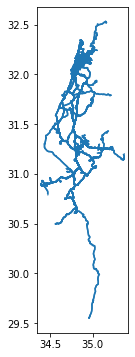

In [110]:
routes.plot();

```{admonition} Exercise 08-b
:class: important
* Repeat creation of the line layer `routes`, as shown above, but this time subset the operator `"דן באר שבע"`.
* Calcualte a `GeoSeries` of starting points of each route. Hint: you can either go over the `"LineString"` geometries and extract the first point using `shapely` methods (see {ref}`linestring-coordinates` and {ref}`shapely-create-specific-functions`), or go back to the point layer and subset the first point per `route_id`.
* Plot the routes and the start points together ({numref}`exercise-08-b`). 
* Note that the default plotting order of `matplotlib` is lines on top of points. To have points on top of lines, specify: 
    * `zorder=1` when plotting the lines, and 
    * `zorder=2` when plotting the points.
```

```{glue:figure} exercise-08-b
---
name: exercise-08-b
---
Solution of exercise-08-b: Routes operated by `"דן באר שבע"` and their start points 
```

We can also explore the routes, or some of them, interactively (see {ref}`geopandas-interactive-maps`). For example, the following expression displays bus lines `"367"`, `"368"`, and `"370"`, which travel between Beer-Sheva, and Rishon Le Zion (`"367"`), Ashdod (`"368"`), and Tel-Aviv (`"370"`). Note that we are using the `.isin` method (see {ref}`pandas-using-isin`) for filtering:

In [111]:
routes1 = routes[routes['route_short_name'].isin(['367', '368', '370'])]
routes1

route_id route_short_name                     route_long_name  \
194      8140              367  ת. מרכזית רשל''צ/רציפים-ראשון ל...   
195      8141              367  ת.מרכזית באר שבע/רציפים בינעירו...   
196      8145              368  ת. מרכזית אשדוד/רציפים-אשדוד<->...   
197      8148              368  ת.מרכזית באר שבע/רציפים בינעירו...   
204      8170              370  ת.מרכזית ת''א ק.6/רציפים-תל אבי...   
205      8171              370  ת.מרכזית באר שבע/רציפים בינעירו...   

                               geometry  
194  LINESTRING (34.78518 31.96795, ...  
195  LINESTRING (34.79679 31.24297, ...  
196  LINESTRING (34.63879 31.79072, ...  
197  LINESTRING (34.79679 31.24297, ...  
204  LINESTRING (34.77978 32.05568, ...  
205  LINESTRING (34.79679 31.24297, ...

Typically, there are two routes for each line, one route per direction, labelled `1#` and `2#`, which is why we got six routes for three lines:

In [112]:
routes1['route_long_name'].to_list()

["ת. מרכזית רשל''צ/רציפים-ראשון לציון<->ת.מרכזית באר שבע/הורדה-באר שבע-1#",
 "ת.מרכזית באר שבע/רציפים בינעירוני-באר שבע<->ת. מרכזית ראשל''צ-ראשון לציון-2#",
 'ת. מרכזית אשדוד/רציפים-אשדוד<->ת.מרכזית באר שבע/הורדה-באר שבע-1#',
 'ת.מרכזית באר שבע/רציפים בינעירוני-באר שבע<->ת. מרכזית אשדוד-אשדוד-2#',
 "ת.מרכזית ת''א ק.6/רציפים-תל אביב יפו<->ת.מרכזית באר שבע/הורדה-באר שבע-1#",
 "ת.מרכזית באר שבע/רציפים בינעירוני-באר שבע<->ת. מרכזית ת''א ק. 6/הורדה-תל אביב יפו-2#"]

When mapping the lines we can keep just one, since the routes of the same line in both directions mostly overlap anyway:

In [113]:
routes1 = routes1.drop_duplicates('route_short_name')
routes1

route_id route_short_name                     route_long_name  \
194      8140              367  ת. מרכזית רשל''צ/רציפים-ראשון ל...   
196      8145              368  ת. מרכזית אשדוד/רציפים-אשדוד<->...   
204      8170              370  ת.מרכזית ת''א ק.6/רציפים-תל אבי...   

                               geometry  
194  LINESTRING (34.78518 31.96795, ...  
196  LINESTRING (34.63879 31.79072, ...  
204  LINESTRING (34.77978 32.05568, ...

Here is an interactive map of the three lines. Here we use another option for specifying `cmap`, using specific color names (which is specific to `.explore`):

In [114]:
routes1.explore(column='route_short_name', cmap=['red', 'green', 'blue'], style_kwds={'weight':8, 'opacity':0.8})

(geopandas-writing)=
## Writing vector layers

A `GeoDataFrame` can be written to file using its [`.to_file`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_file.html) method. This is useful for:

* Permanent storage of the data, for future analysis or for sharing your results with other people
* Examining the result in other software, such as GIS software, for validation or exploration of your results

The default output format of `.to_file` is the *Shapefile*. For example, the following expression writes the `routes` line layer (see {ref}`geopandas-point-to-line-by-group`) into a Shapefile named `routes.shp` in the `output` directory. When exporting a Shapefile with non-English text, we sould also specify the encoding, such as `encoding="utf-8"`:

In [115]:
routes.to_file('output/routes.shp', encoding='utf-8')

/home/michael/.local/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
<ipython-input-115-cb7921ec749b>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  routes.to_file("output/routes.shp", encoding="utf-8")


Now we can permanently store the layer of bus routes, share it with a colleague, or open it in another program such as QGIS ({numref}`routes-layer-in-qgis`). 

```{figure} images/routes_in_qgis.png
---
name: routes-layer-in-qgis
---
The `routes` layer, exported to Shapefile and opened in QGIS
```

Writing to GeoJSON and GeoPackage formats is similar, only that we need to specify the `driver` name using the string `"GeoJSON"` or `"GPKG"`, respectively:

In [116]:
routes.to_file('output/routes.geojson', driver='GeoJSON')
routes.to_file('output/routes.gpkg', driver='GPKG')

/home/michael/.local/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/michael/.local/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Note that if the output file already exists—it will be overwritten!

(exercise-geopandas1)=
## More exercises

```{admonition} Exercise 08-c
:class: important
* In this exercise, you need to use the statistical areas layer (`statisticalareas_demography2019.gdb`) to find out which towns have the highest, or lowest, proportions of young (0-19) residents. To do that, go through the following steps.
* Read the statistical areas layer (`statisticalareas_demography2019.gdb`).
* Subset the columns `"SHEM_YISHUV"`, `"age_0_4"`, `"age_5_9"`, `"age_10_14"`, `"age_15_19"`, and `"Pop_Total"`. Note that the result is a `DataFrame`, since the geometry column was not included.
* Replace the "No Data" values in the `"age_0_4"`, `"age_5_9"`, `"age_10_14"`, `"age_15_19"`, and `"Pop_Total"` columns with zero (as these represent zero population).
* Sum the `"age_0_4"`, `"age_5_9"`, `"age_10_14"`, and `"age_15_19"` columns to calculate a new column named `"Pop_Total_0_19"`, which represents the total population in ages 0-19 per polygon.
* Subset only those towns with `"Pop_Total"` greater than `5000`.
* Aggregate by town name (`"SHEM_YISHUV"` column), while calculating the sum of the `"Pop_Total_0_19"` and the `"Pop_Total"` columns.
* Calculate the ratio between the young and total population, by dividing the `"Pop_Total_0_19"` column by the `"Pop_Total"` column, and store it in a new column named `"ratio"`.
* Reclassify the `"ratio"` values into two categories:
    * `"young"`—Where the `"ratio"` is *above* the average of the entire `"ratio"` column.
    * `"old"`—Where the `"ratio"` is *below* the average of the entire `"ratio"` column.
* Print the five towns with the highest and lowest `"ratio"` values ({numref}`exercise-08-c`).
```

```{glue:figure} exercise-08-c
---
name: exercise-08-c
---
Solution of exercise-08-c: Towns with the highest and lowest proportions of young (0-19) residents
```

```{admonition} Exercise 08-d
:class: important
* Start with the `routes` layer with all routes operated by `"מטרופולין"` (see {ref}`geopandas-point-to-line-by-group`).
* Calculate `delta_lon` and `delta_lat` columns, with $x_{max}-x_{min}$  and $y_{max}-y_{min}$ per route, respectively. Hint: use the `.bounds` property (see {ref}`geopandas-bounds`).
* Subset the route that has maximal `delta_lon` and the route that has the maximal `delta_lat`, i.e., the route that has the widest and the tallest bounding box, respectively ({numref}`exercise-08-d1`).
* Plot the two routes using different colors ({numref}`exercise-08-d2`).

```{glue:figure} exercise-08-d1
---
name: exercise-08-d1
---
Solution of exercise-08-d1: Routes by `"מטרופולין"` with maximal `delta_lon` and `delta_lat` (table view)
```

```{glue:figure} exercise-08-d2
---
name: exercise-08-d2
---
Solution of exercise-08-d2: Routes by `"מטרופולין"` with maximal `delta_lon` and `delta_lat` (plot)
```